---
title: Clustering Algorithms - KMeans, KCenter, Single Linkage Agglomeration
author: "Guntas Singh Saran"
date: "2024-02-05"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Clustering"]

---

## Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from os.path import join
import struct
from array import array
import random
from sklearn.metrics import rand_score
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
latexify(columns = 2)

## MNIST Data Class Loader from Kaggle

In [5]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

### Loading the Training-Testing Images and Labels

In [6]:
input_path = './archive'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

### Helper Function to show list of images with their labels

In [7]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap = "inferno")
        if (title_text != ''):
            plt.title(title_text, fontsize = 20);        
        index += 1

## Loading the MNIST Dataset

In [8]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

### Shape of the Training-Testing Data

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### Some of the Digits

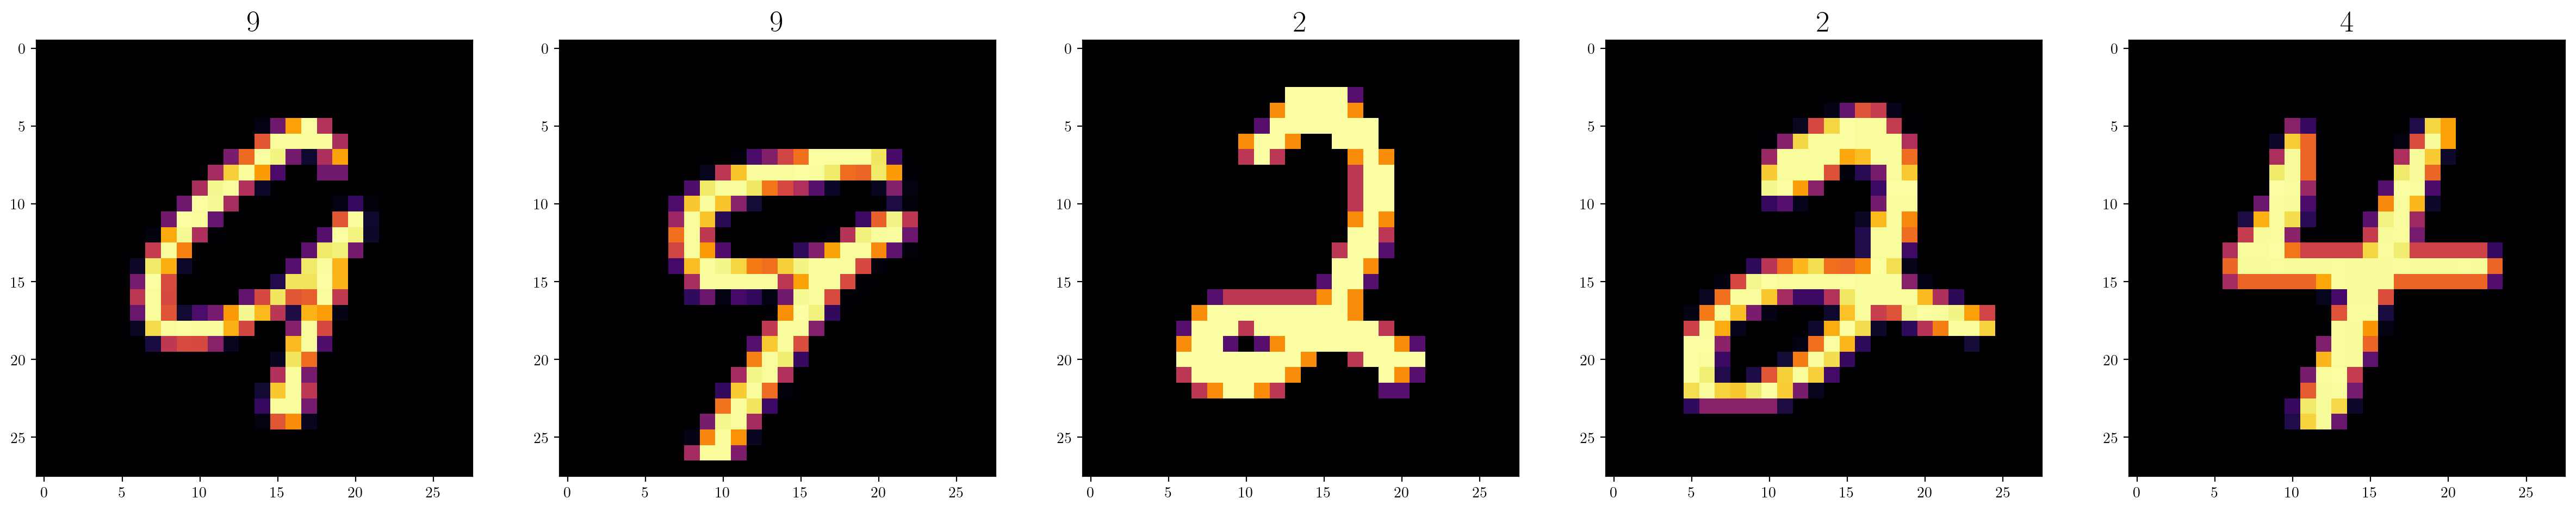

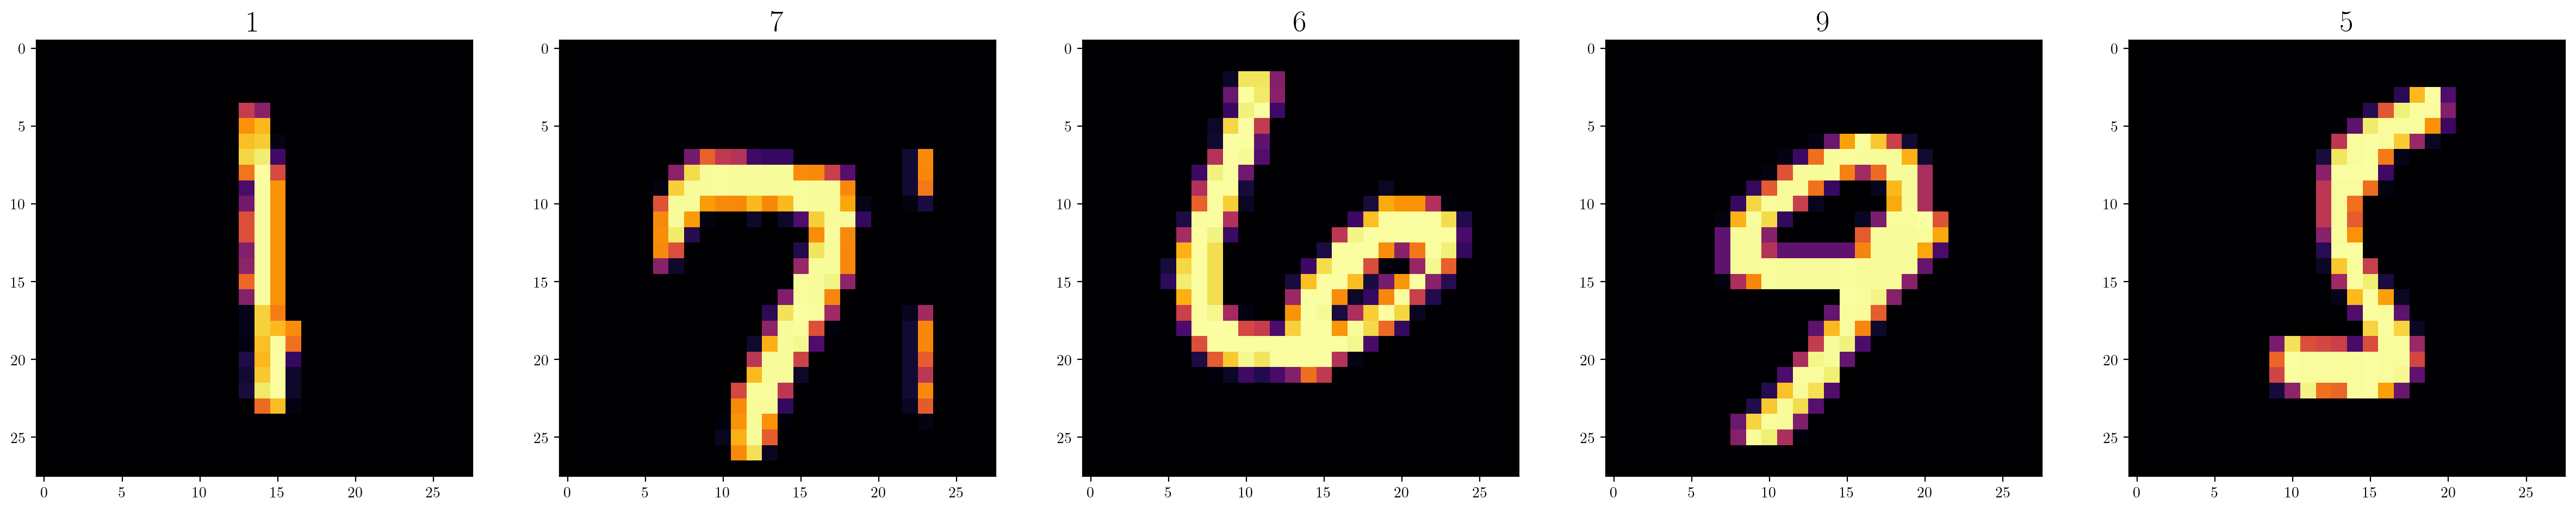

In [11]:
rand_idx = np.random.choice(10000, 5, replace = False)
show_images(x_train[rand_idx], y_train[rand_idx])
show_images(x_test[rand_idx], y_test[rand_idx])

### Random Images displayed

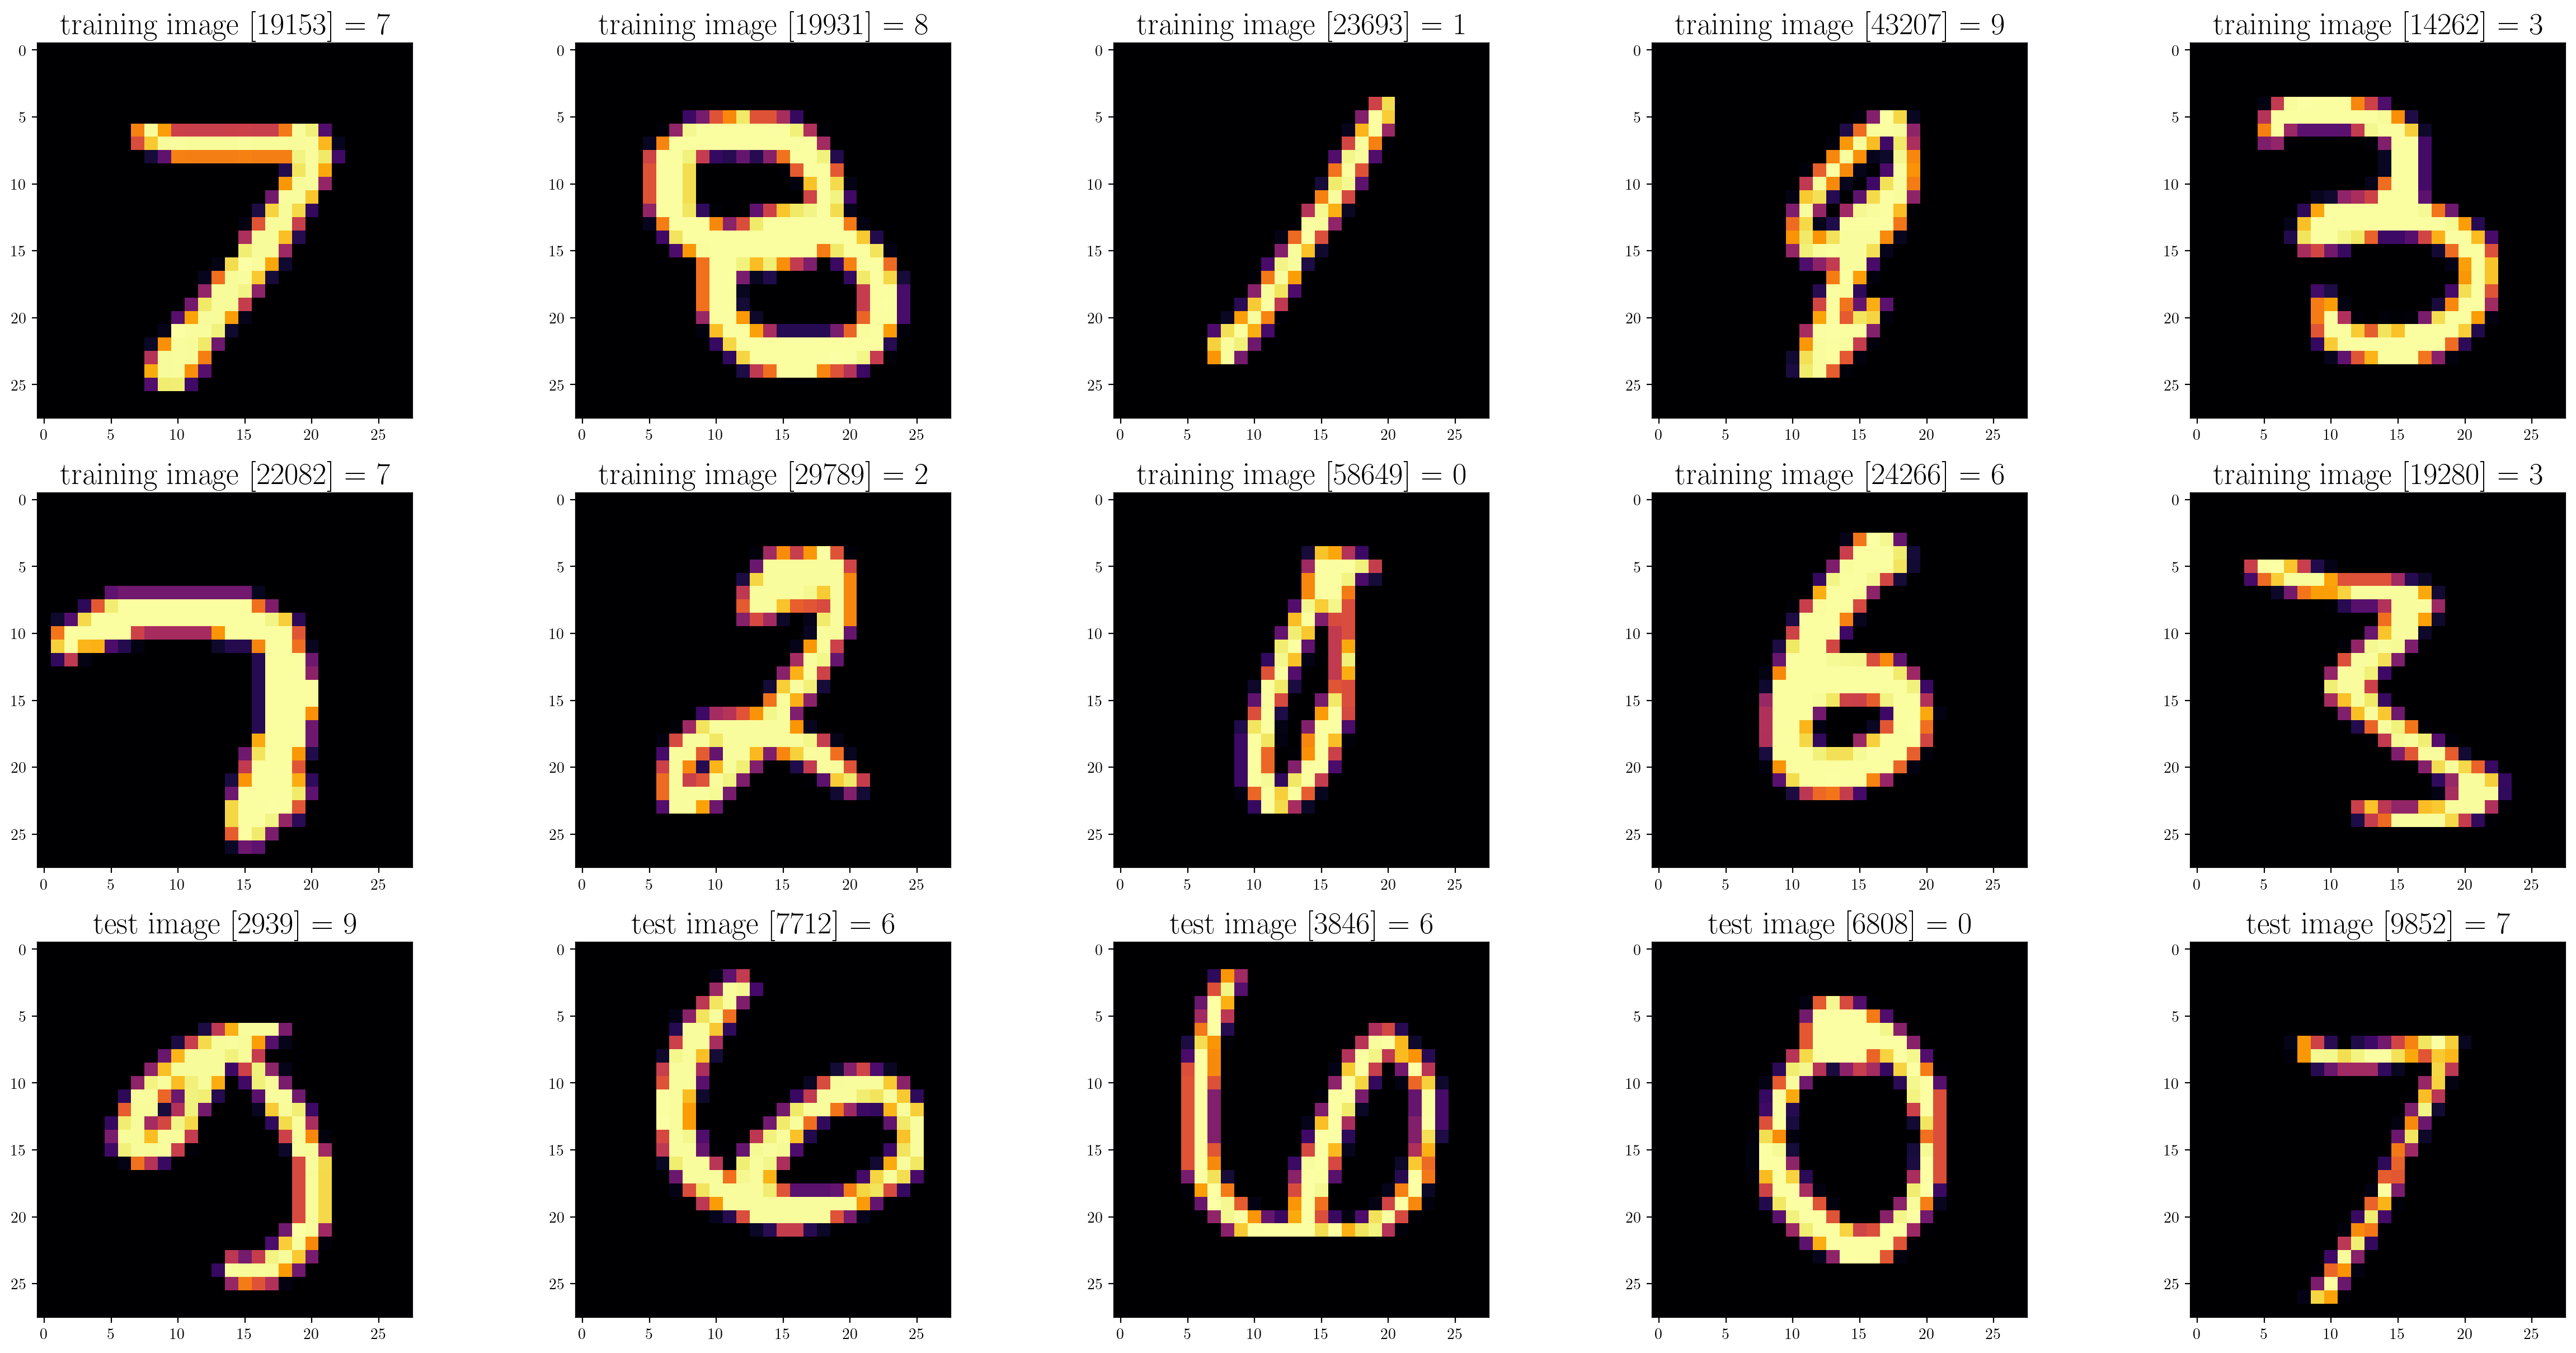

In [12]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Q3. K-Means and K-Center on Test Dataset $10,000$ datapoints in $\mathbb{R}^{784}$

In [13]:
x_test.shape

(10000, 28, 28)

In [10]:
def flatten_out(data):
    return data.reshape(data.shape[0], -1)

In [15]:
x_test_flatten = flatten_out(x_test)
x_test_flatten.shape

(10000, 784)

# K-Means using Llyod's Algorithm with KMeans++ initialization

### The Algorithm
#### For a given partition:
- Find the centers of the current partition
- Assign points to the nearest center
- Recalculate the centers
- Terminate when centers don't shift much or no point changes the partition
  
#### The cost function:
#### $\text{cost(C)} = \underset{x}{\operatorname{\sum}}$ $\underset{c_x}{\operatorname{min}}$ $d(x, c_x)^2$
#### Objective is to minimise the variance of each cluster, the variance
#### $\text{var}(C_i) = \underset{x \in C_i}{\operatorname{\sum}}$ $||x - C_i||^2$
#### which is minimised at the **mean** of each cluster
#### $\overline{C_i} = \frac{1}{|C_i|} \underset{x \in C_i}{\operatorname{\sum}}$ $x$

### KMeans++ Initialization
- Choose the initial point randomly
- For each remaining points $x$, compute $D(x)$, the distance between $x$ and the nearest center already chosen.
- Choose a new point as center with probability $\frac{D(x)^{\alpha}}{\sum D(y)^{\alpha}}$, where $\alpha = 2$ untill $k$ centers have been chosen.
- This is done by creating a CDF $F_X(x)$ for the above probability distribution at each iteration of $k$ runs. A uniform random variable $U$ when substituted into the invervse of CDF of $X$, returns the random drawn $x$ i.e. $x = F_X^{-1}(U)$
- To achieve this for our discrete CDF, we'll generate a uniform sample using ```np.random.rand()``` and find the closest value to it in the discrete CDF and extract the index of the corresponding point, following is the code snippet for it:

```python
    dist = np.min(np.linalg.norm(X[:, None] - centroids, axis = -1)[:, :i], axis = 1)
    probs = dist**2 / np.sum(dist**2)
    cdf = np.cumsum(probs)
    r = np.random.rand()
    my_idx = np.argmin(np.abs(cdf - r))
``` 

- Else we may use ```np.random.choice(A, p = ProbabilityDistribution)``` by explicitly providing the probability distribution of sampling

In [88]:
class KMeansPP:
    def __init__(self, n_clusters, max_iter = 300, tol = 1e-4):
        self.k = n_clusters
        self.iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels = None
    
    def fit(self, X):
        """
            Choosing the new center based upon the probability distribution
            probab_dist = distances_from_their_centers ** alpha / np.sum(distances_from_their_centers ** alpha)
        """
        alpha = 2
        self.centroids = np.zeros((self.k, X.shape[1]))
        self.centroids[0] = X[np.random.randint(X.shape[0])]
        for i in range(1, self.k):
            dist = np.min(np.linalg.norm(X[:, None] - self.centroids, axis = -1)[:, :i], axis = 1)
            probs = dist**alpha / np.sum(dist**alpha)
            self.centroids[i] = X[np.random.choice(X.shape[0], p = probs)]
        
        """
            Now k centers are chosen, so we need to 
            run the iterations of Llyod's Algorithm
        """
        iter = 0
        while (iter <= self.iter or np.sum(np.linalg.norm(self.centroids - prev_centroids)) >= self.tol):
            distances = np.linalg.norm(X[:, None] - self.centroids, axis = -1)
            self.labels = np.argmin(distances, axis = 1)
            prev_centroids = self.centroids.copy()
            self.centroids = np.array([X[self.labels == i].mean(axis = 0) for i in range(self.k)])
            iter += 1
    
    def predict(self, X_):
        return np.argmin(np.linalg.norm(X_[:, None] - self.centroids, axis = -1), axis = 1)
        

In [165]:
k = 10
model = KMeansPP(n_clusters = k, max_iter = 20, tol = 1e-4)
model.fit(flatten_out(x_test))

### Obtained $k$ Centers from the KMeans++ initialization in only $20$ iterations

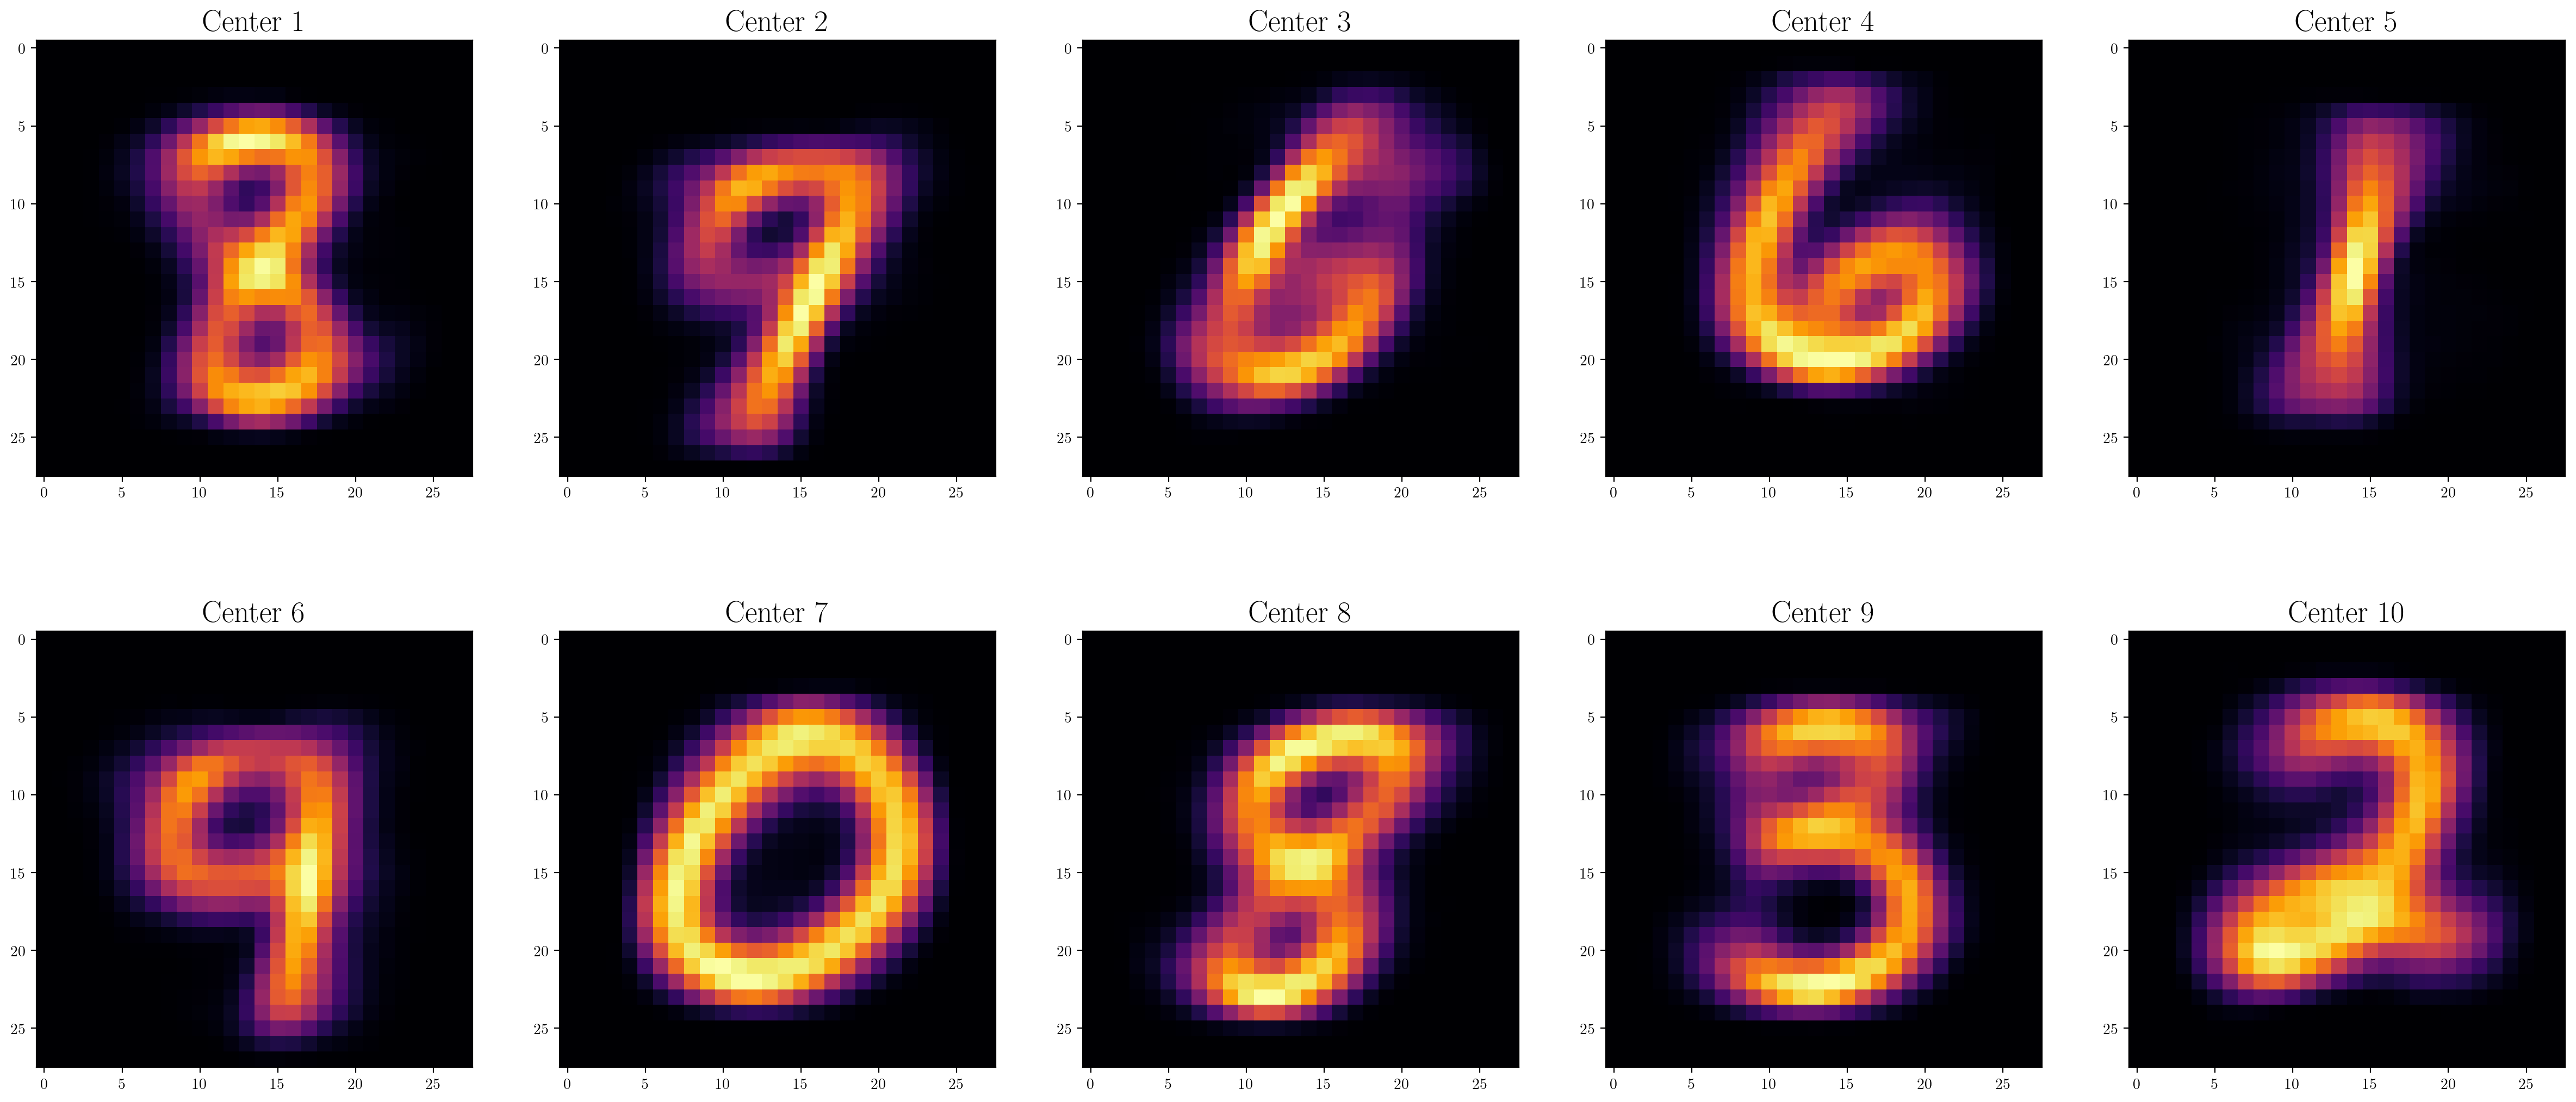

In [166]:
centersPlot = model.centroids.reshape((k, 28, 28))
show_images(centersPlot, [f"Center {i}" for i in range(1, 11)])

In [167]:
pred_labels = model.labels
print(pred_labels)
print(y_test)

[1 2 4 ... 1 2 3]
[7 2 1 ... 4 5 6]


In [168]:
rand_score(pred_labels, y_test)

0.8884620462046204

# K-Center Greedy Algo

### The Algorithm
- Choose first center arbitrarily
- For each of the remaining $(k - 1)$ centers, choose the furthest point from the chosen centers untill all $k$ centers have been found
  
### How to choose the further point from the choosen centers?
#### Let $G_i = \set{g_1, g_2, \ldots, g_i}$ be the set of $i$ chosen centers, then we define $d(x, G_i)$ as: <br>
#### $ d(x, G_i) = \underset{g \in G_i}{\operatorname{min}}$ $d(x, g) $
#### And the new center $g_{i + 1}$ as:
#### $g_{i + 1} = \underset{x}{\operatorname{argmax}}$ $d(x, G_i)$
#### Further we define maximum value of distance as $\Delta_{i} = \underset{x}{\operatorname{max}}$ $d(x, G_i)$
#### that is, from the distances of a point $x$ from each of the $i$ centers, pickout the minimum distance (denoted by $ d(x, G_i)$) from the $i$ centers and for all $x$ in the dataset, choose the point with the maximum of these minimum distance (denoted by $g_{i + 1}$ )
#### The cost of entire clustering $D_{\text{algo}}$ also denoted as $\Delta(G)$, is the maximum of the further distances of points from their respective centers. This means that we may place a ball of radius $\Delta(G)$ over each of the $k$ centers and we'll be able to cover all points

In [89]:
class KCenter:
    def __init__(self, k = 10):
        self.k = k
        self.centers = None
        self.labels = None
    
    def fit(self, X):
        self.centers = np.zeros((self.k, X.shape[1]))
        self.centers[0] = X[np.random.randint(X.shape[0])]
        distances = np.zeros((X.shape[0], self.k))
        for i in range(1, self.k):
            for j in range(i):
                distances[:, j] = np.linalg.norm(X - self.centers[j], axis = 1)
            self.centers[i] = X[np.argmax(np.min(distances[:, :i], axis = 1))]
        self.labels = np.argmin(np.linalg.norm(X - self.centers[:, None], axis = 2), axis = 0)

    def predict(self, X_train):
        return np.argmin(np.linalg.norm(X_train - self.centers[:, None], axis = 2), axis = 0)

In [86]:
k = 10
model = KCenter(k = k)
model.fit(flatten_out(x_test))

### Obtained $k$ Centers from the KCenter Algorithm

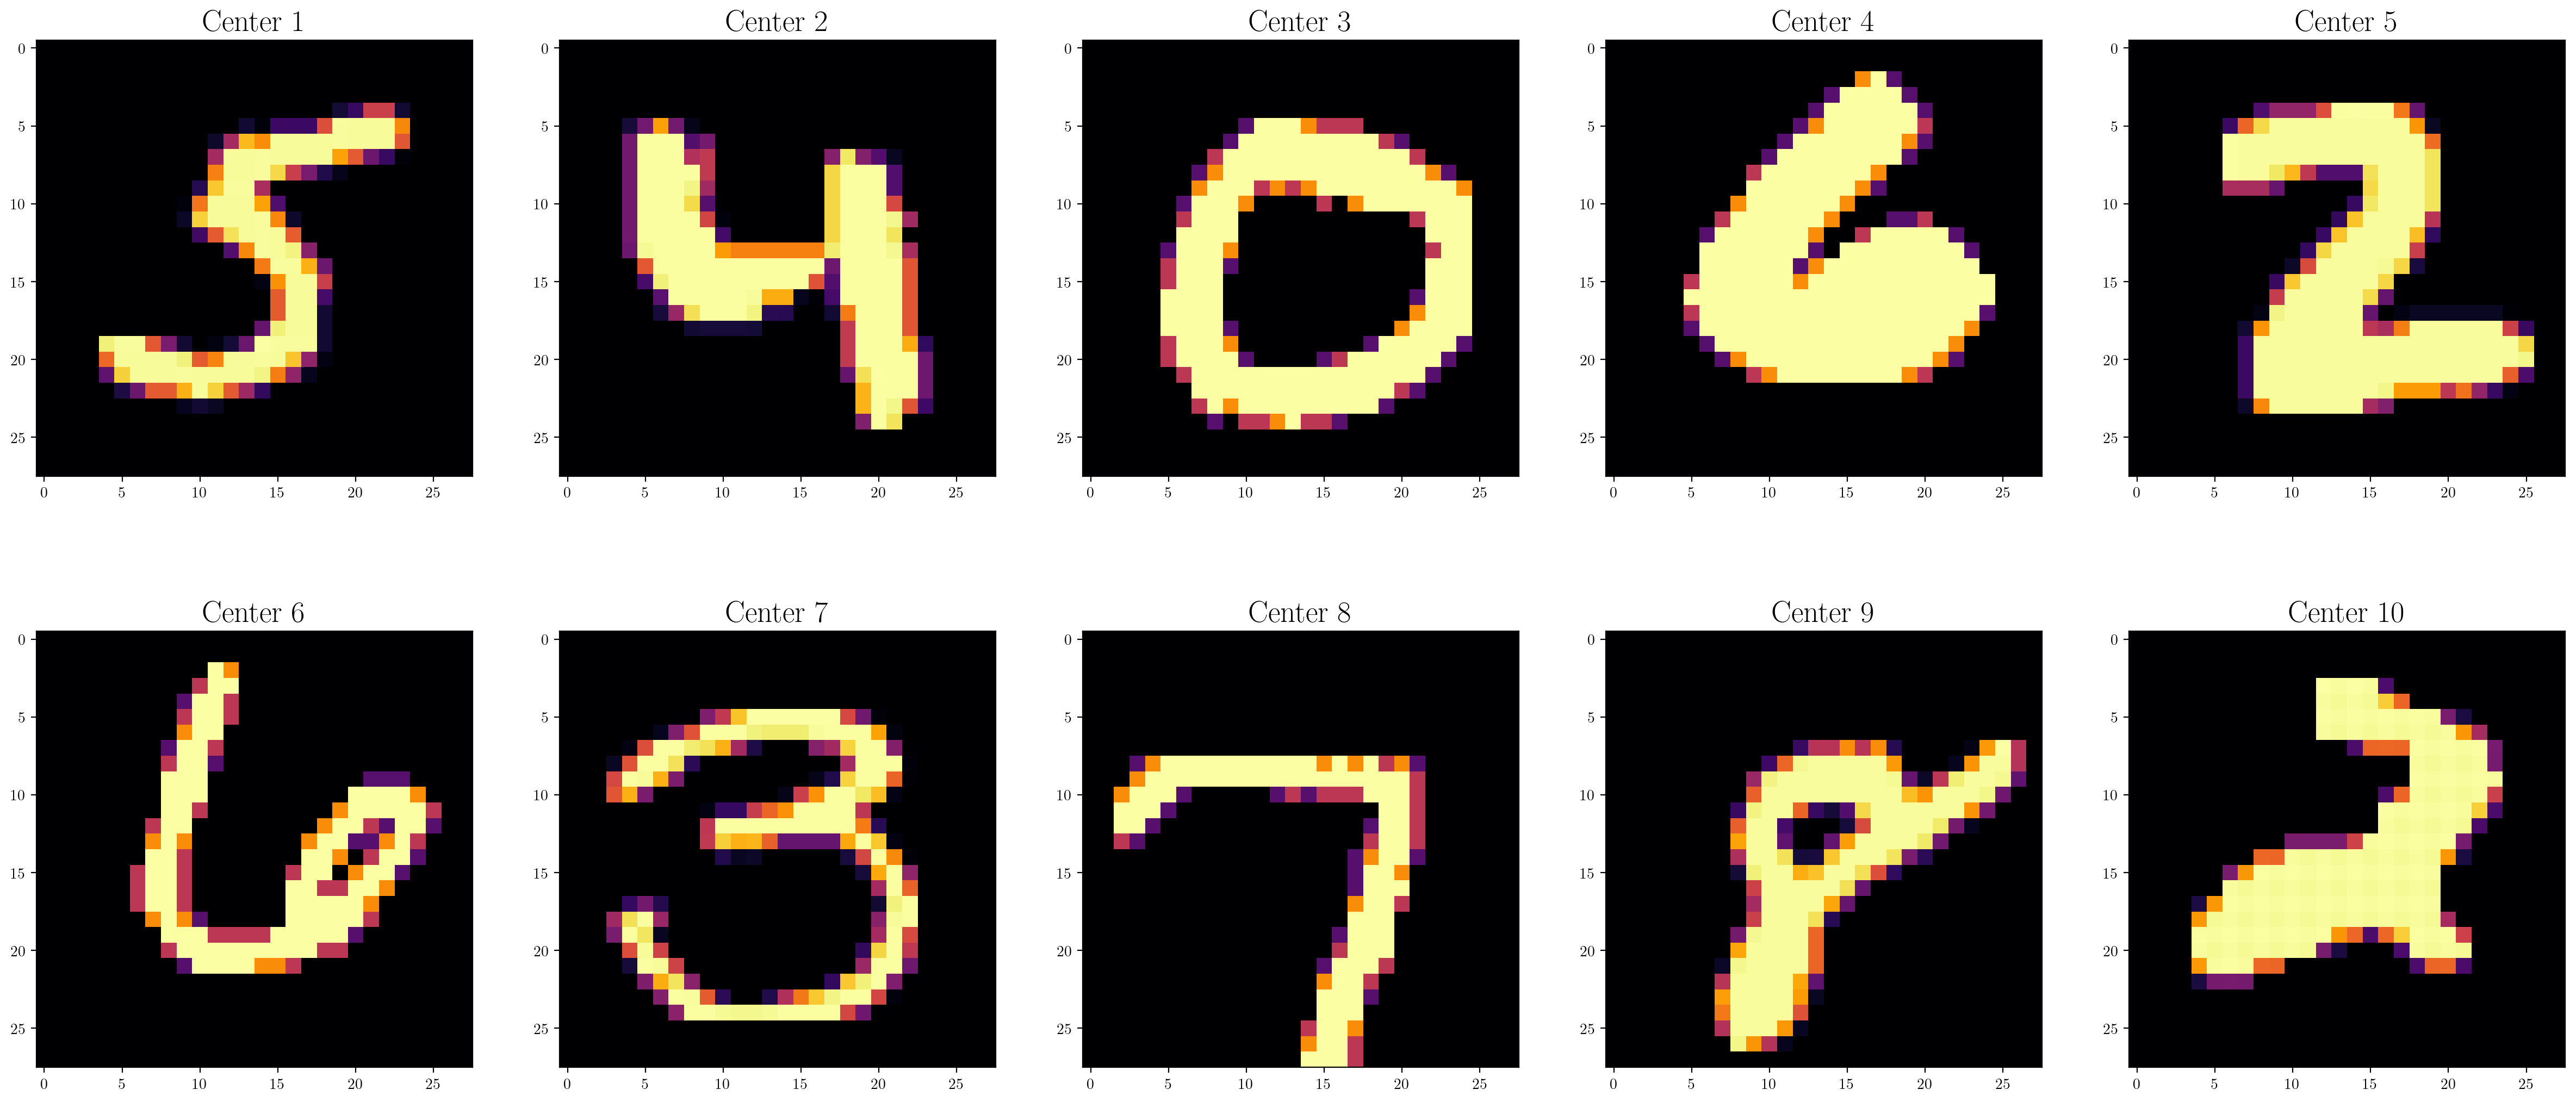

In [87]:
centersPlot = model.centers.reshape((k, 28, 28))
show_images(centersPlot, [f"Center {i}" for i in range(1, 11)])

In [88]:
pred_labels = model.labels
print(pred_labels)
print(y_test)

[7 4 0 ... 8 0 3]
[7 2 1 ... 4 5 6]


In [92]:
rand_score(pred_labels, y_test)

0.6772203820382038

# Single Linkage Agglomeration

### Closeness Metric is the **closest pair distance**
#### $D(C_1, C_2) = \underset{x \in C_1, y \in C_2}{\operatorname{\min}} d(x, y)$
#### $O(N^3)$

In [232]:
from scipy.spatial.distance import squareform, pdist
from IPython.display import clear_output
import time

class SingleLinkageAgglomeration:
    def __init__(self, n_clusters = 10):
        self.k = n_clusters
        self.clusters = None
        self.labels = None
        self.point_clusters = []
        
    def fit(self, X):
        self.clusters = [[i] for i in range(X.shape[0])]
        while (len(self.clusters) > self.k):
            if (len(self.clusters) == X.shape[0]):
                D = squareform(pdist(X, metric = "euclidean"))
            
            # clear_output(wait = True)
            # print(D.shape)
            
            # print(self.clusters)
            # l = 0
            # for cluster in self.clusters:
            #     l += len(cluster)
            # print(l)
            
            D_argmin = D.copy()
            np.fill_diagonal(D_argmin, np.inf)
            D_argmin[np.triu_indices(D.shape[0])] = np.inf


            row, col = np.unravel_index(np.argmin(D_argmin), D.shape)
            merged_column = np.minimum(D[:, row], D[:, col])

            merged_column = np.delete(merged_column, row)
            # print(row, col)
            row, col = sorted([row, col])
            
            

            deleted_D = np.delete(np.delete(D, col, axis = 1), col, axis = 0)
            deleted_D[row] = merged_column
            deleted_D[:, row] = merged_column
            
            """
                [[0], [1], [2], [3], [4]]
                with [row, col] = [0, 2]
                will become
                [[0, 2], [1], [3], [4]]
                
                Further with [row, col] = [0, 2]
                will become
                [[0, 2, 3], [1], [4]]
            
            """
            # print()
            
            
            self.clusters[row].extend(self.clusters[col])
            self.clusters.pop(col)
            D = deleted_D.copy()
            
            # time.sleep(0.00001)
            
        self.labels = np.zeros(X.shape[0])
        for cluster_idx, cluster in enumerate(self.clusters):
            self.labels[cluster] = int(cluster_idx)
        
        for i in range(self.k):
            self.point_clusters.append(X[self.labels == i])
        
        
    def predict(self, X):
        predictions = np.zeros(X.shape[0])

        for i, x in enumerate(X):
            distances_to_clusters = np.zeros(self.k)
            
            for cluster_idx, cluster_points in enumerate(self.point_clusters):
                distances_to_clusters[cluster_idx] = np.min(np.linalg.norm(cluster_points - x, axis = 1))
            
            predictions[i] = np.argmin(distances_to_clusters)

        return predictions

#### Model Fitting for the random $30$ points showing the merging of clusters along with the merge indices

In [228]:
k = 10
model = SingleLinkageAgglomeration(n_clusters = k)
rand_idx = np.random.choice(10000, 30, replace = False)
X = flatten_out(x_test)[rand_idx]
model.fit(X)

(30, 30)
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
30
29 19

(29, 29)
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19, 29], [20], [21], [22], [23], [24], [25], [26], [27], [28]]
30
18 14

(28, 28)
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14, 18], [15], [16], [17], [19, 29], [20], [21], [22], [23], [24], [25], [26], [27], [28]]
30
12 4

(27, 27)
[[0], [1], [2], [3], [4, 12], [5], [6], [7], [8], [9], [10], [11], [13], [14, 18], [15], [16], [17], [19, 29], [20], [21], [22], [23], [24], [25], [26], [27], [28]]
30
15 5

(26, 26)
[[0], [1], [2], [3], [4, 12], [5, 16], [6], [7], [8], [9], [10], [11], [13], [14, 18], [15], [17], [19, 29], [20], [21], [22], [23], [24], [25], [26], [27], [28]]
30
21 1

(25, 25)
[[0], [1, 24], [2], [3], [4, 12], [5, 16], [6], [7], [8], [9], [

In [229]:
for idx, elt in enumerate(model.clusters):
    print(f"Cluster {idx} has {len(elt)} points")

Cluster 0 has 1 points
Cluster 1 has 4 points
Cluster 2 has 13 points
Cluster 3 has 4 points
Cluster 4 has 1 points
Cluster 5 has 1 points
Cluster 6 has 3 points
Cluster 7 has 1 points
Cluster 8 has 1 points
Cluster 9 has 1 points


#### Final Clusters and the Labels

In [230]:
print(model.clusters)
print(model.labels)

[[0], [1, 24, 13, 2], [3, 4, 12, 14, 18, 11, 22, 19, 29, 10, 6, 21, 28], [5, 16, 7, 9], [8], [15], [17, 26, 20], [23], [25], [27]]
[0. 1. 1. 2. 2. 3. 2. 3. 4. 3. 2. 2. 2. 1. 2. 5. 3. 6. 2. 2. 6. 2. 2. 7.
 1. 8. 6. 9. 2. 2.]


#### Rand-Index

In [231]:
rand_score(model.labels, y_test[rand_idx])

0.7862068965517242

#### Plotting the points in the $2^{nd}$ cluster

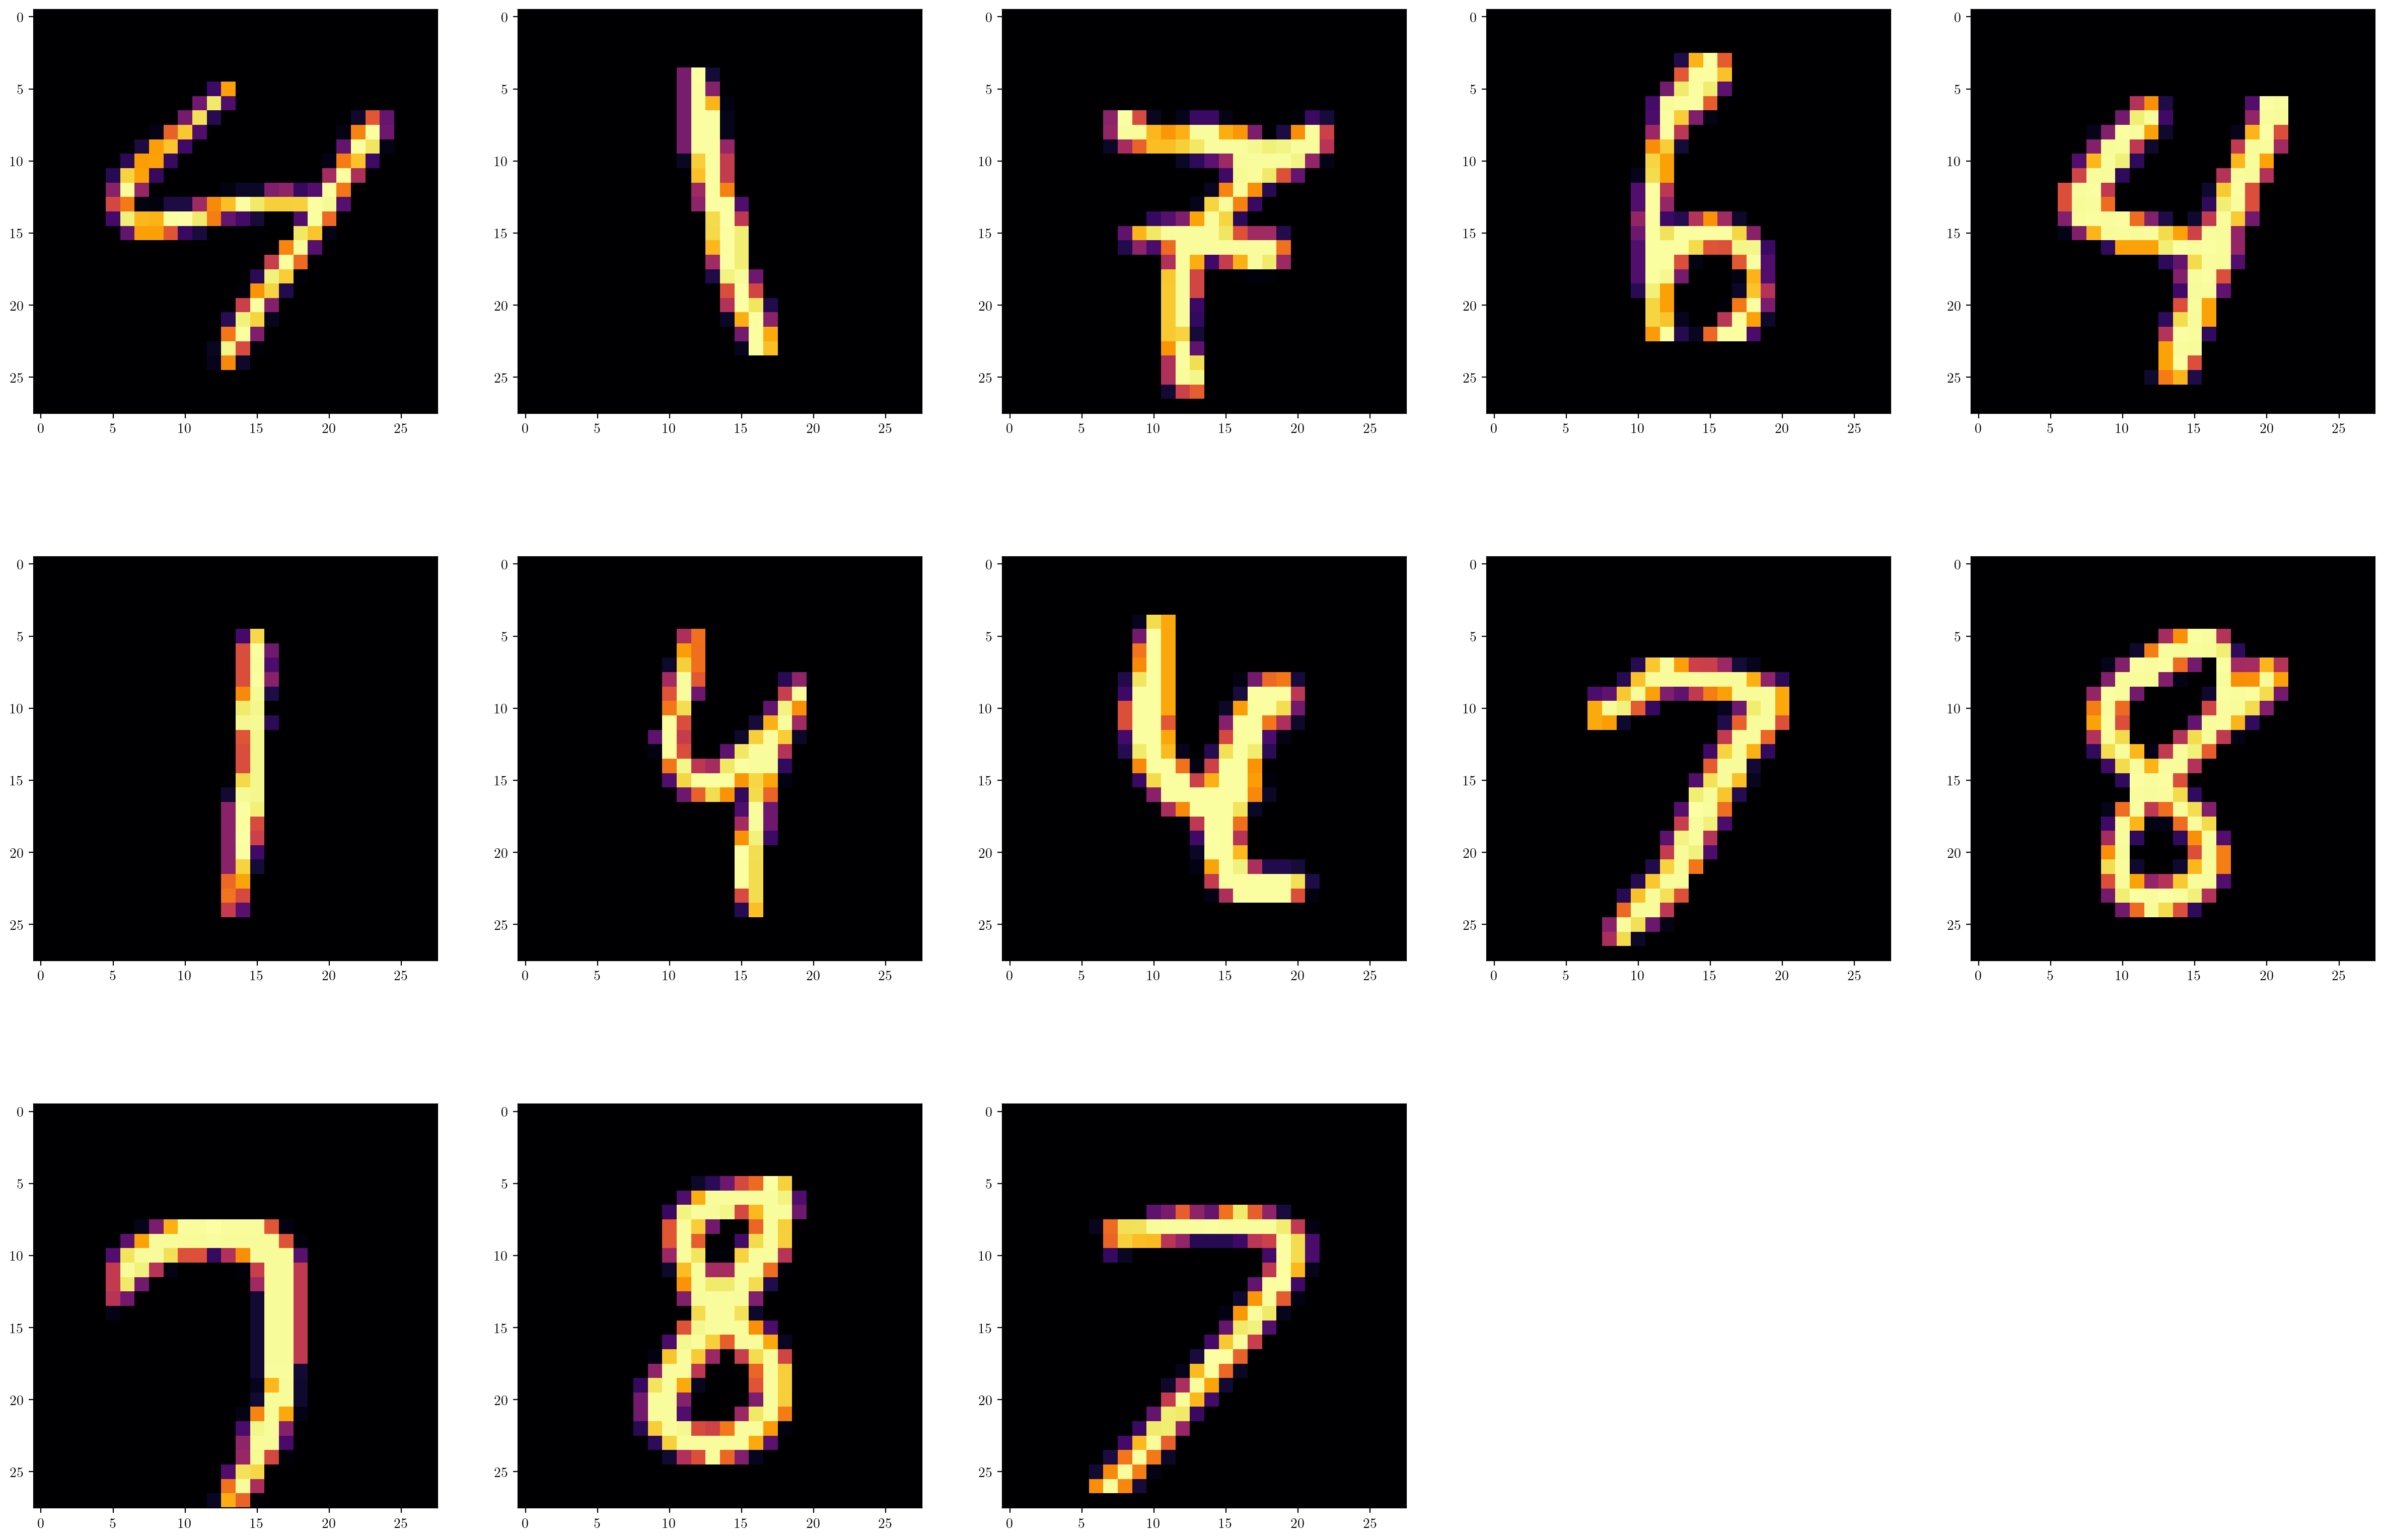

In [233]:
show_images(model.point_clusters[2].reshape(-1, 28, 28), [f"" for i in range(len(model.point_clusters[2]))])

#### Fitting on the entire test data

In [234]:
k = 10
model = SingleLinkageAgglomeration(n_clusters = k)
X = flatten_out(x_test)
model.fit(X)

In [235]:
for idx, elt in enumerate(model.clusters):
    print(f"Cluster {idx} has {len(elt)} points")

Cluster 0 has 9991 points
Cluster 1 has 1 points
Cluster 2 has 1 points
Cluster 3 has 1 points
Cluster 4 has 1 points
Cluster 5 has 1 points
Cluster 6 has 1 points
Cluster 7 has 1 points
Cluster 8 has 1 points
Cluster 9 has 1 points


In [236]:
print(model.clusters)
print(model.labels)

[[0, 494, 4800, 1784, 1799, 9340, 1919, 3973, 9314, 7650, 1925, 9270, 2187, 7082, 9288, 9806, 3079, 5485, 3993, 8134, 6825, 5277, 2563, 2567, 6586, 7654, 4991, 8688, 8791, 1564, 263, 4970, 5540, 6837, 1321, 6805, 746, 6852, 3719, 4913, 6874, 4459, 7677, 229, 4493, 2252, 2646, 2591, 2887, 5402, 5798, 2262, 8591, 2275, 8654, 7180, 254, 6845, 941, 6316, 2844, 2967, 1576, 705, 6871, 1705, 3637, 8742, 8727, 9859, 8749, 1699, 383, 4295, 666, 2463, 3040, 9864, 9935, 9816, 7307, 9837, 5234, 6267, 1624, 3632, 3162, 1710, 4612, 9869, 1935, 4049, 6856, 9448, 6361, 7632, 5326, 8874, 9101, 8871, 5482, 1346, 3400, 9851, 4784, 6960, 6963, 7355, 4624, 4669, 438, 2399, 6830, 5162, 585, 8608, 6253, 1359, 2301, 9823, 2059, 4561, 911, 3643, 2238, 5563, 9990, 4773, 4677, 7021, 8421, 5324, 2290, 1563, 2234, 1171, 2141, 3609, 8617, 8638, 8651, 4568, 9413, 7276, 5789, 1006, 4760, 411, 1507, 4028, 1071, 6198, 7286, 7296, 6223, 7300, 3736, 1175, 2132, 946, 223, 1770, 2490, 5040, 4061, 7605, 8074, 3009, 7493, 99

In [237]:
rand_score(model.labels, y_test)

0.1017039703970397

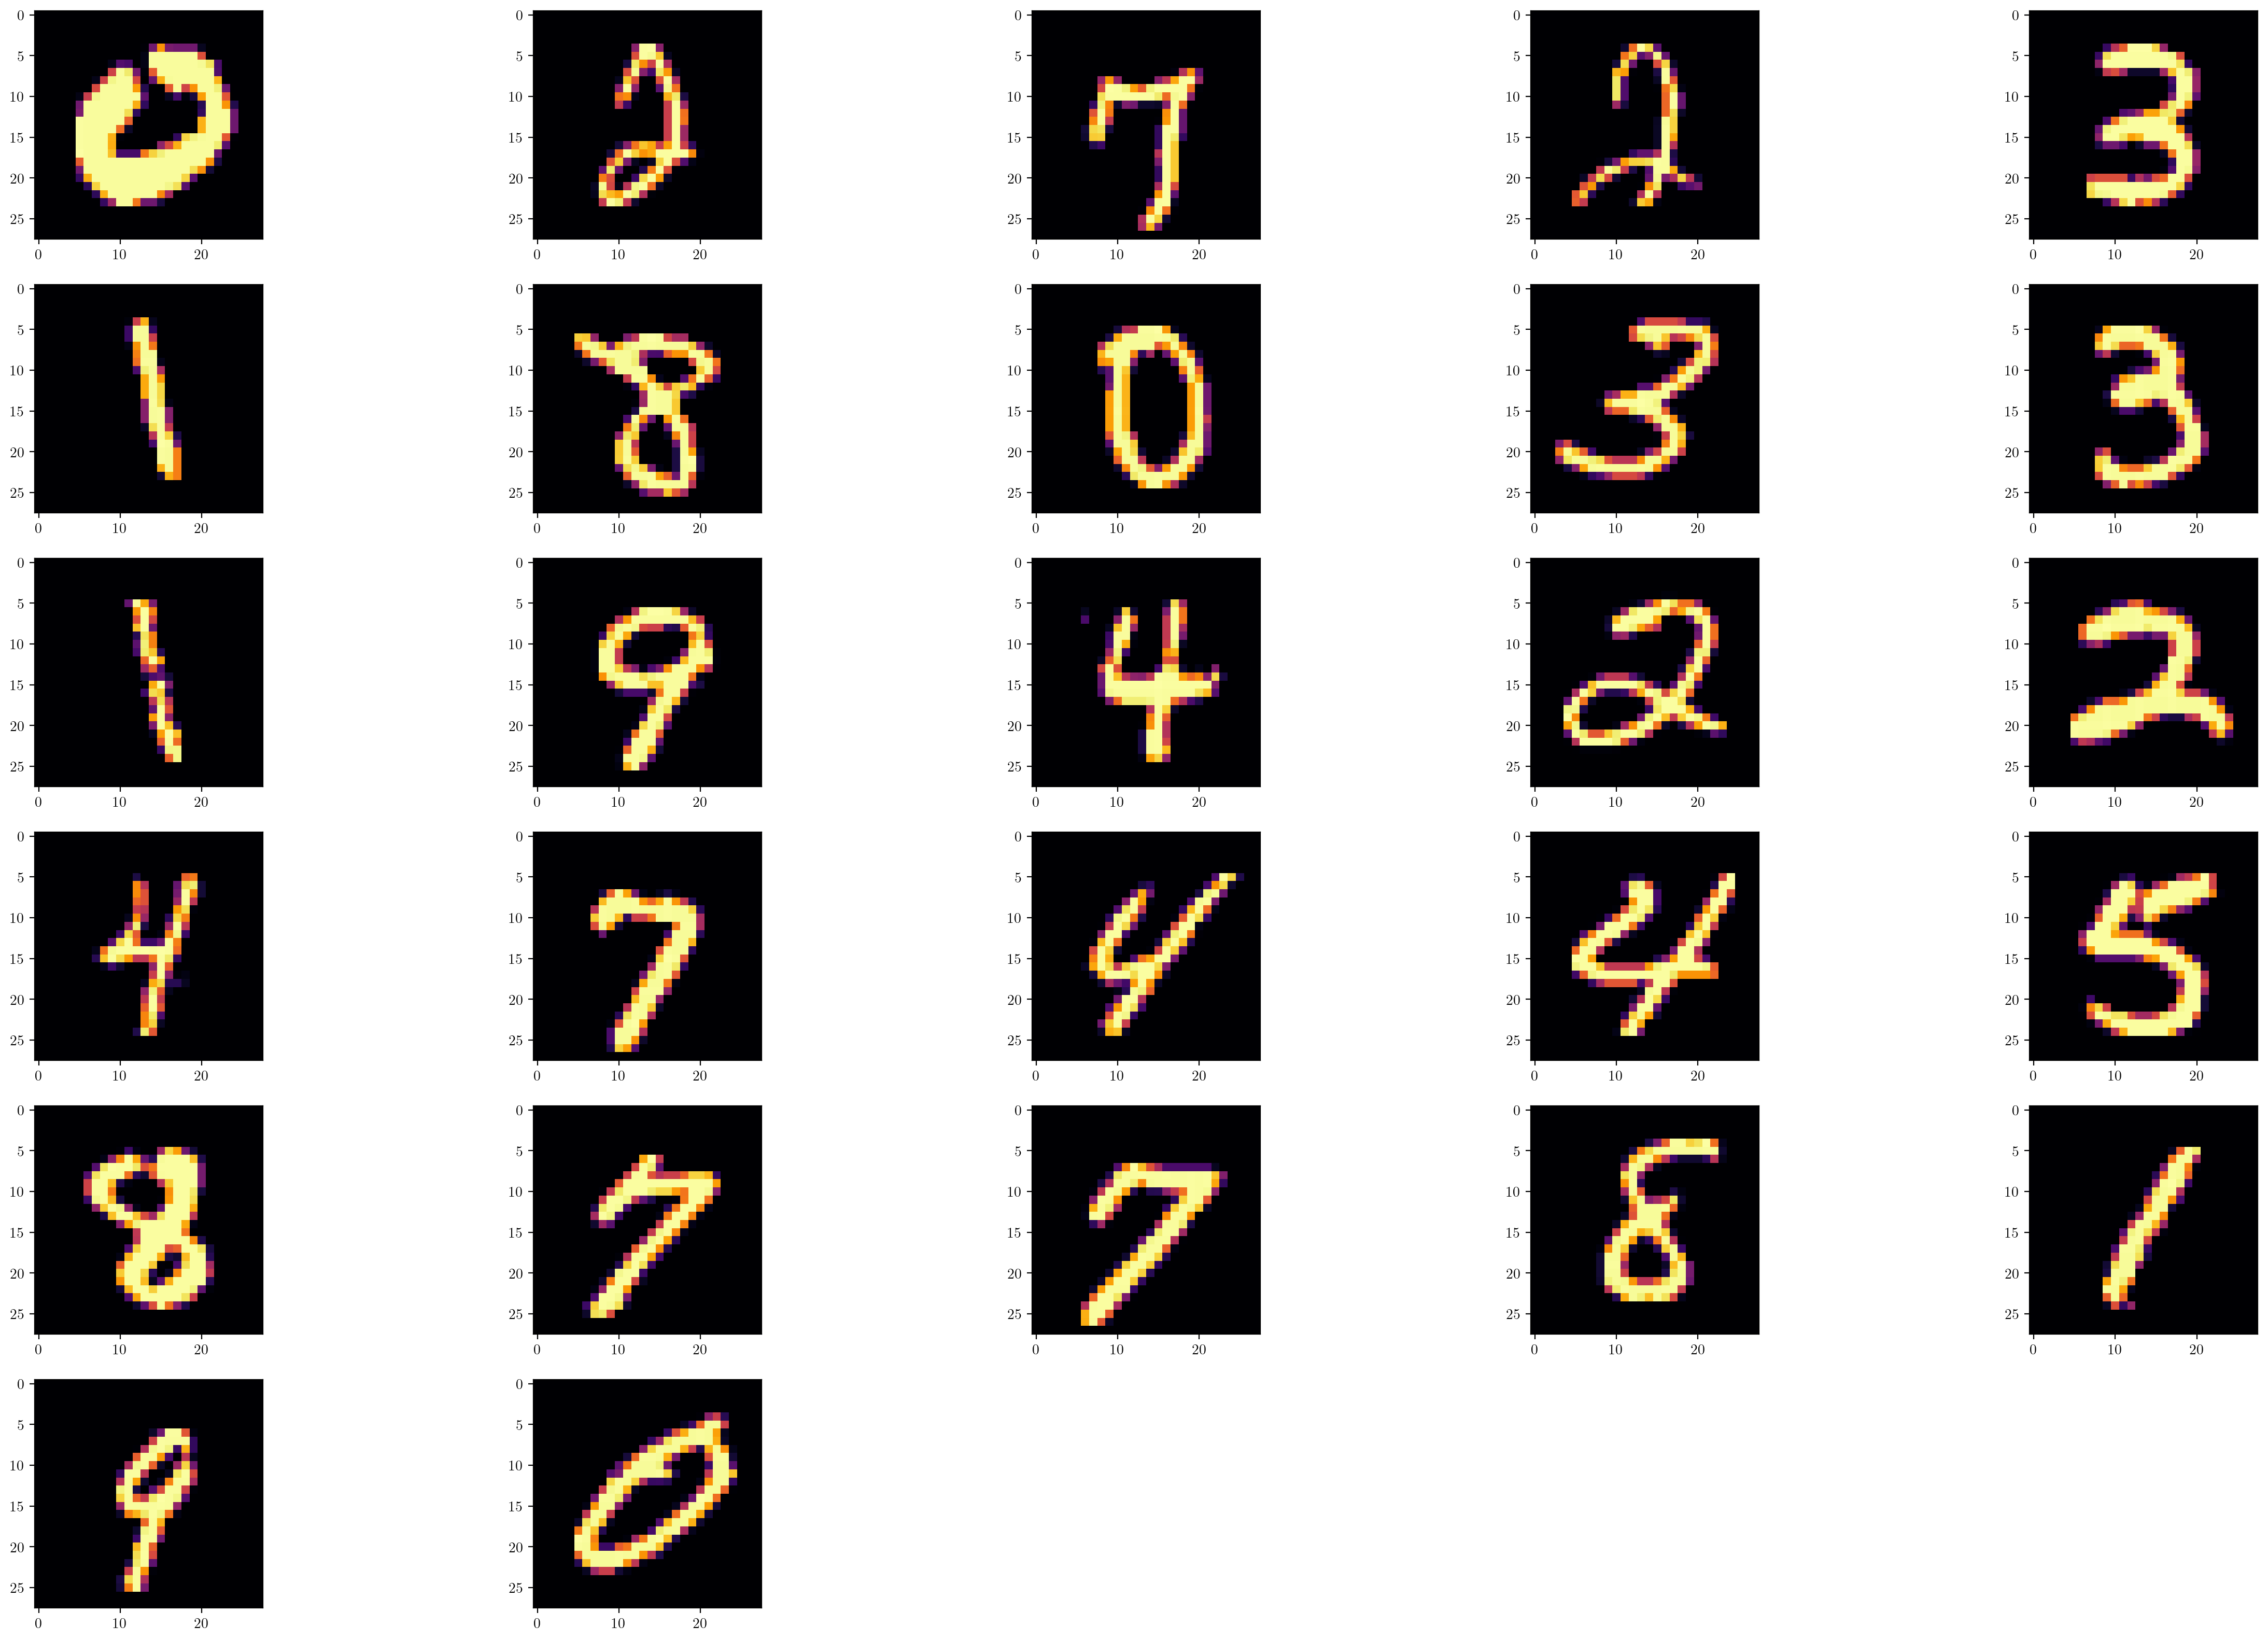

In [76]:
show_images(model.point_clusters[1].reshape(-1, 28, 28), [f"" for i in range(len(model.point_clusters[1]))])

### Intuition behind the ```fit()``` method above
#### Source: [Wikipedia](https://en.wikipedia.org/wiki/Single-linkage_clustering)
#### Source: [Revoledu](https://people.revoledu.com/kardi/tutorial/Clustering/Numerical%20Example.htm)

In [166]:
ids = [[x] for x in range(6)]

# # Example 1
# D = np.array([[0, 17, 21, 31, 23],
#           [17, 0, 30, 34, 21],
#           [21, 30, 0, 28, 39],
#           [31, 34, 28, 0, 43],
#           [23, 21, 39, 43, 0]], dtype = float)

# Example 2
D = np.array([[0, 0.71, 5.66, 3.61, 4.24, 3.20],
          [0.71, 0, 4.95, 2.92, 3.54, 2.50],
          [5.66, 4.95, 0, 2.24, 1.41, 2.50],
          [3.61, 2.92, 2.24, 0, 1.00, 0.50],
          [4.24, 3.54, 1.41, 1.00, 0, 1.12],
          [3.20, 2.50, 2.50, 0.50, 1.12, 0.00]], dtype = float)


for i in range(5):
    print(f"Iteration {i}:")

    D_argmin = D.copy()
    np.fill_diagonal(D_argmin, np.inf)
    D_argmin[np.triu_indices(D.shape[0])] = np.inf

    print(f"Original Distance Matrix:\n{D}")


    row, col = np.unravel_index(np.argmin(D_argmin), D.shape)
    merged_column = np.minimum(D[:, row], D[:, col])

    merged_column = np.delete(merged_column, row)
    print(f"Merged Column: {merged_column}")
    print(f"(Row, Col) = {row}, {col}")
    
    row, col = sorted([row, col])
    
    

    deleted_D = np.delete(np.delete(D, col, axis = 0), col, axis = 1)
    deleted_D[row] = merged_column
    deleted_D[:, row] = merged_column

    print()
    print(f"New Distance Matrix:\n{deleted_D}")

   
    print(f"Original Clusters: {ids}")


    ids[row].extend(ids[col])
    ids.pop(col)
    print(f"\nNew Clusters: {ids}\n\n")
    D = deleted_D.copy()


Iteration 0:
Original Distance Matrix:
[[0.   0.71 5.66 3.61 4.24 3.2 ]
 [0.71 0.   4.95 2.92 3.54 2.5 ]
 [5.66 4.95 0.   2.24 1.41 2.5 ]
 [3.61 2.92 2.24 0.   1.   0.5 ]
 [4.24 3.54 1.41 1.   0.   1.12]
 [3.2  2.5  2.5  0.5  1.12 0.  ]]
Merged Column: [3.2  2.5  2.24 0.   1.  ]
(Row, Col) = 5, 3

New Distance Matrix:
[[0.   0.71 5.66 3.2  4.24]
 [0.71 0.   4.95 2.5  3.54]
 [5.66 4.95 0.   2.24 1.41]
 [3.2  2.5  2.24 0.   1.  ]
 [4.24 3.54 1.41 1.   0.  ]]
Original Clusters: [[0], [1], [2], [3], [4], [5]]

New Clusters: [[0], [1], [2], [3, 5], [4]]


Iteration 1:
Original Distance Matrix:
[[0.   0.71 5.66 3.2  4.24]
 [0.71 0.   4.95 2.5  3.54]
 [5.66 4.95 0.   2.24 1.41]
 [3.2  2.5  2.24 0.   1.  ]
 [4.24 3.54 1.41 1.   0.  ]]
Merged Column: [0.   4.95 2.5  3.54]
(Row, Col) = 1, 0

New Distance Matrix:
[[0.   4.95 2.5  3.54]
 [4.95 0.   2.24 1.41]
 [2.5  2.24 0.   1.  ]
 [3.54 1.41 1.   0.  ]]
Original Clusters: [[0], [1], [2], [3, 5], [4]]

New Clusters: [[0, 1], [2], [3, 5], [4]]


I

## Utility of Single Linkage Clustering over KMeans

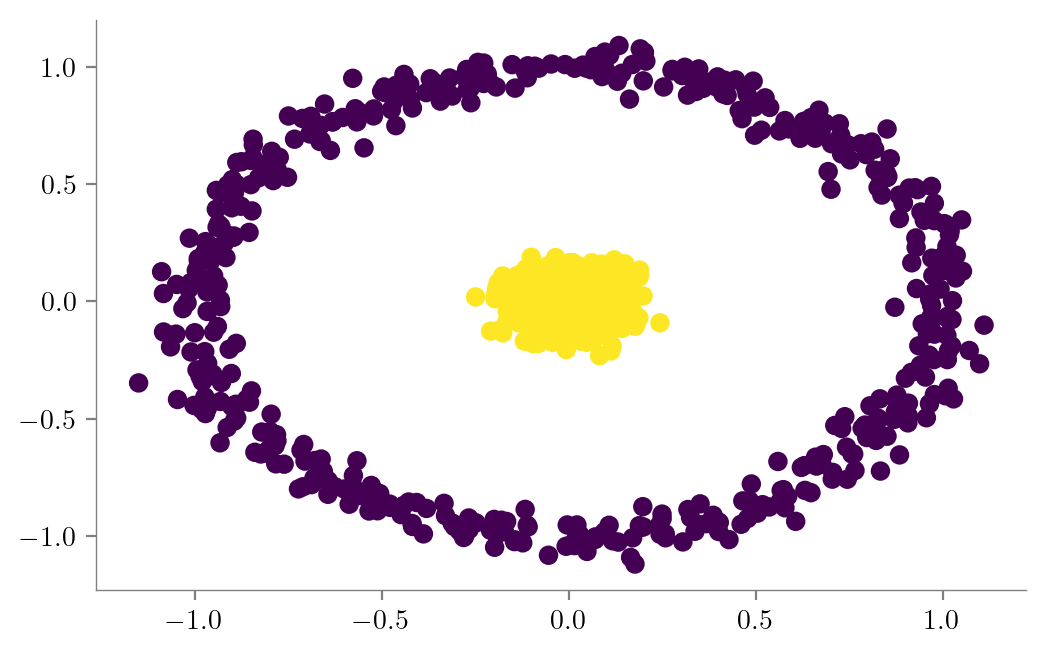

In [220]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples = 1000, noise = 0.05, factor = 0.1)
latexify(columns = 2, fig_width = 6)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = "viridis")
format_axes(plt.gca())
plt.show()

In [202]:
X.shape, y.shape

((1000, 2), (1000,))

### KMeans on the above dataset

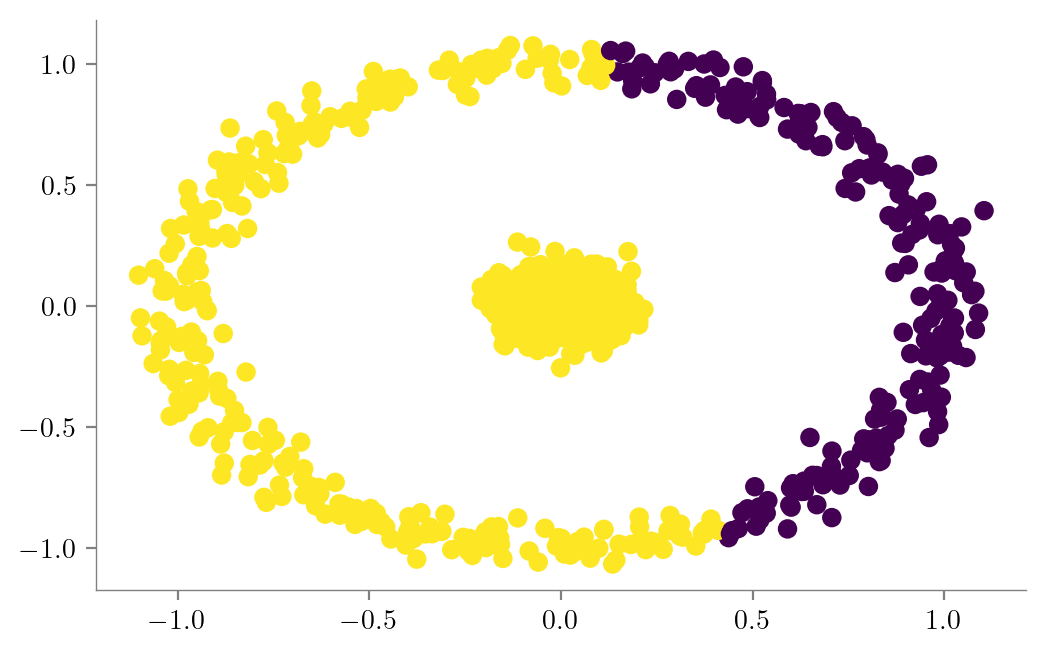

In [203]:
k = 2
model = KMeansPP(n_clusters = k, max_iter = 20, tol = 1e-4)
model.fit(X)
latexify(columns = 2, fig_width = 6)
plt.scatter(X[:, 0], X[:, 1], c = model.labels, cmap = "viridis")
format_axes(plt.gca())
plt.show()

## KCenter on the above dataset

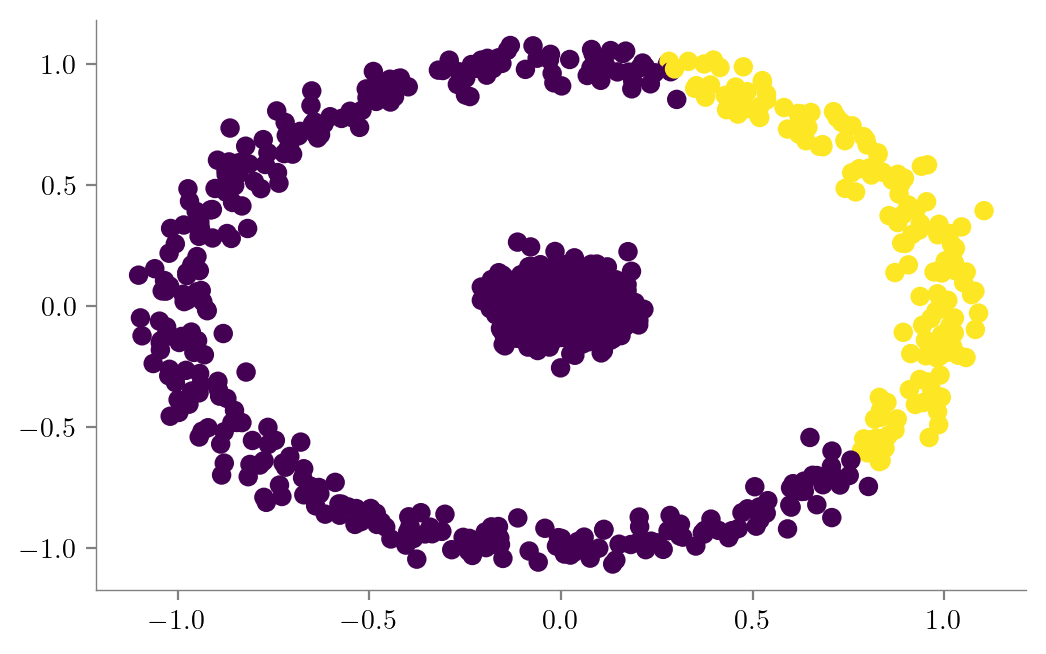

In [204]:
k = 2
model = KCenter(k = k)
model.fit(X)
latexify(columns = 2, fig_width = 6)
plt.scatter(X[:, 0], X[:, 1], c = model.labels, cmap = "viridis")
format_axes(plt.gca())
plt.show()

## Single Linkage Clustering on the above dataset

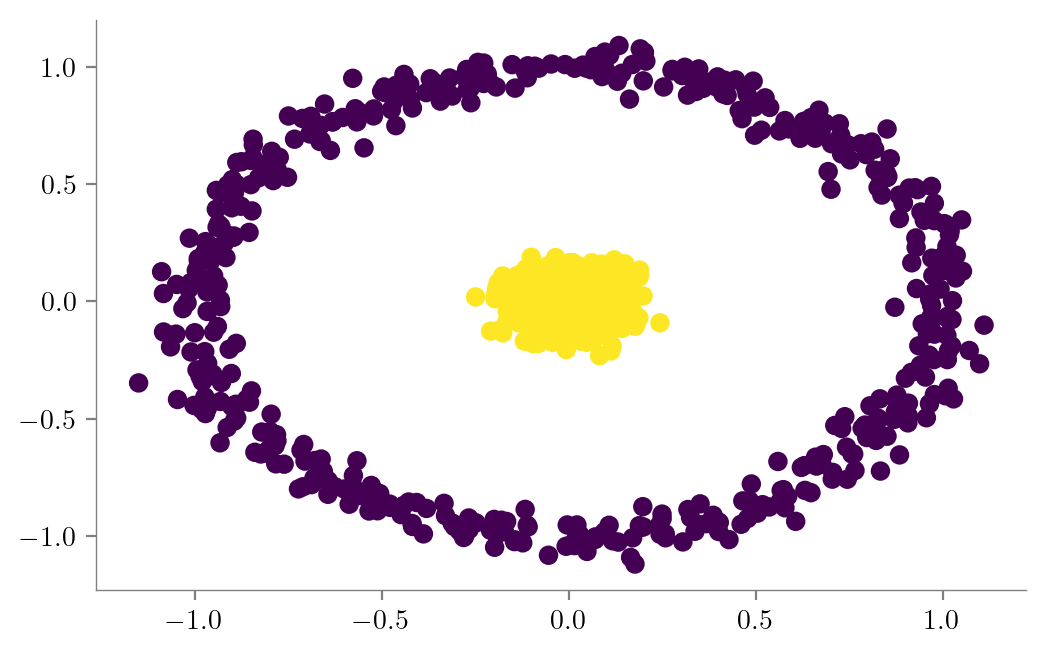

In [221]:
k = 2
model = SingleLinkageAgglomeration(n_clusters = k)
model.fit(X)
latexify(columns = 2, fig_width = 6)
plt.scatter(X[:, 0], X[:, 1], c = model.labels, cmap = "viridis")
format_axes(plt.gca())
plt.show()

In [222]:
len(model.clusters[0])

500